# Logisitic smooth regression model

Following van der Wiel et al. 2019, let's model energy demand using a logistic smooth regression model: https://www.sciencedirect.com/science/article/pii/S1364032119302862

This takes a single predictor, daily mean temperature, and provides a smooth transition between two linear regimes.

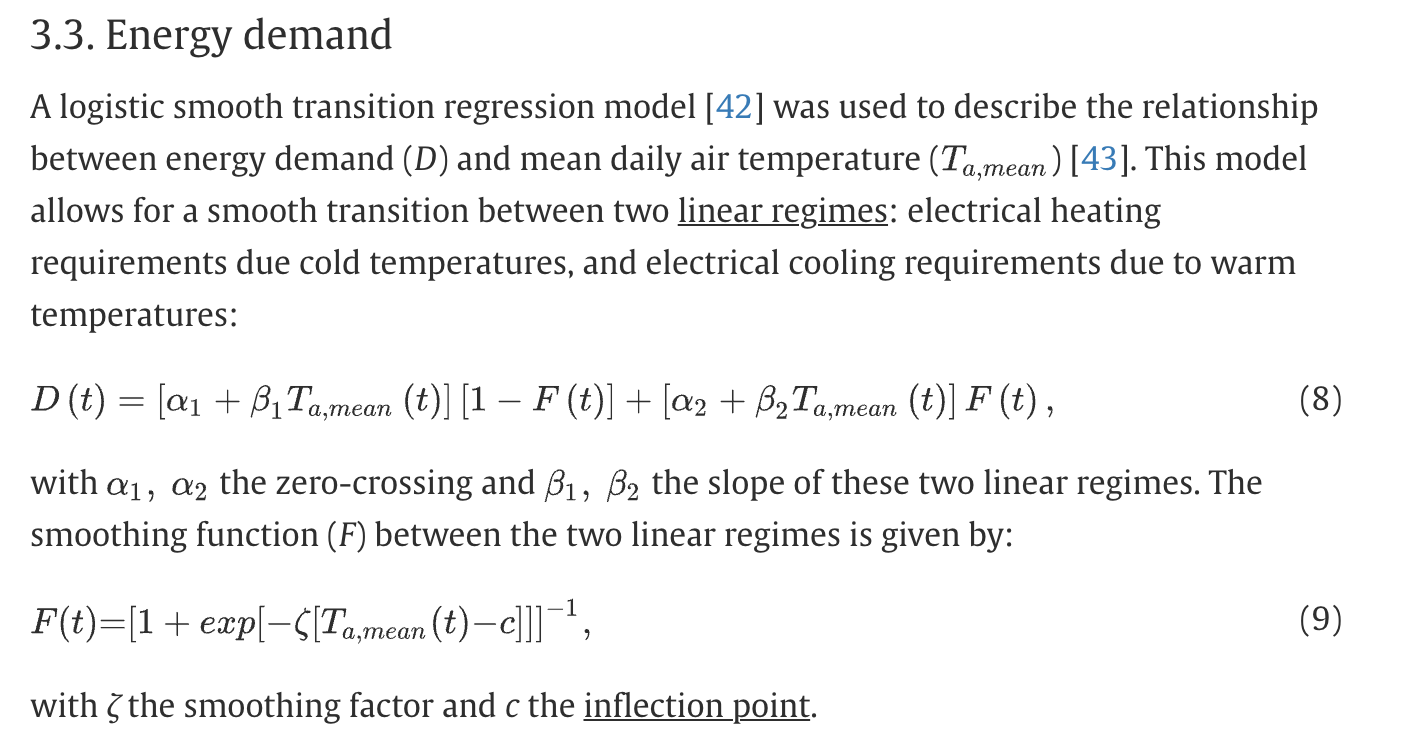

In [15]:
import xarray as xr
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error

from scipy.stats import spearmanr, pearsonr

import matplotlib.pyplot as plt

In [2]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

# Load predictors and predictands

Detrended energy demand (predictand)

In [3]:
aus_dem = xr.open_dataset(
    path + "/data/energy_demand/daily_demand_2010-2020_detrended.nc"
)["demand_dt"]

In [4]:
eu_dem = xr.open_dataset(
    path + "data/energy_demand/EU_daily_demand_2010-2020_detrended.nc"
)["demand_dt"]

Daily mean temperature

In [5]:
aus_t2m = xr.open_dataset(path + "demand_predictors/2t_era5_daily_1959-2022_NEM.nc")["t2m"]

In [6]:
eu_t2m = xr.open_dataset(path + "demand_predictors/2t_era5_daily_1959-2022_EU.nc")["t2m"]

# Plot demand versus temperature

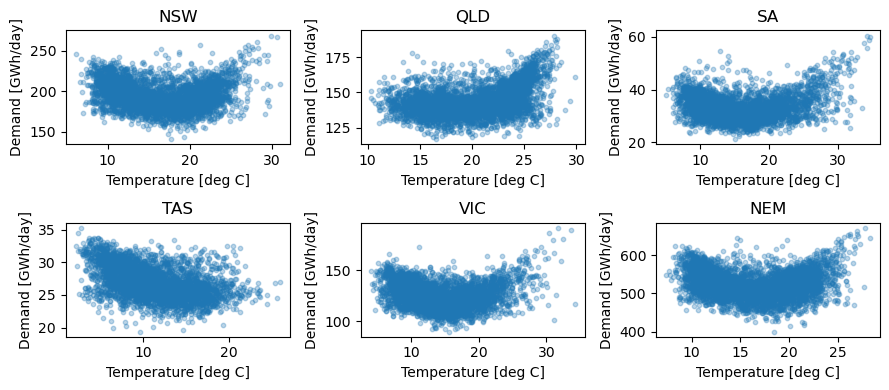

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(9,4))
for i, region in enumerate(aus_dem["region"].values):
    a = ax.flatten()[i]
    a.scatter(
        aus_t2m.sel(region=region, time=aus_dem["time"]) - 273.15,
        aus_dem.sel(region=region) / 1000,
        alpha=0.3,
        s=10
    )
    a.set_xlabel("Temperature [deg C]")
    a.set_ylabel("Demand [GWh/day]")
    a.set_title(region)
plt.tight_layout()

# Try using `scipy` `curve_fit`

In [9]:
from scipy.optimize import curve_fit

In [10]:
def lstr(x, a1, a2, b1, b2, z, c):
    """
    Logistic smooth transition equation
    """
    F = 1 / (1 + np.exp(-z * (x - c)))
    term1 = (a1 + b1 * x) * (1 - F)
    term2 = (a2 + b2 * x) * F
    return term1 + term2

In [11]:
def fit_model(xda, yda, inits):
    """
    Fit logistic smooth transition regression to data.
    """
    x = xda.values
    y = yda.values
    
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    
    params, _ = curve_fit(lstr, x, y, p0=inits, maxfev=25000)
    return params

Need to guess starting parameter values otherwise fitting will fail

In [16]:
init = [-6e6, -4e3, 2e3, 2e1, 0.2, 0]

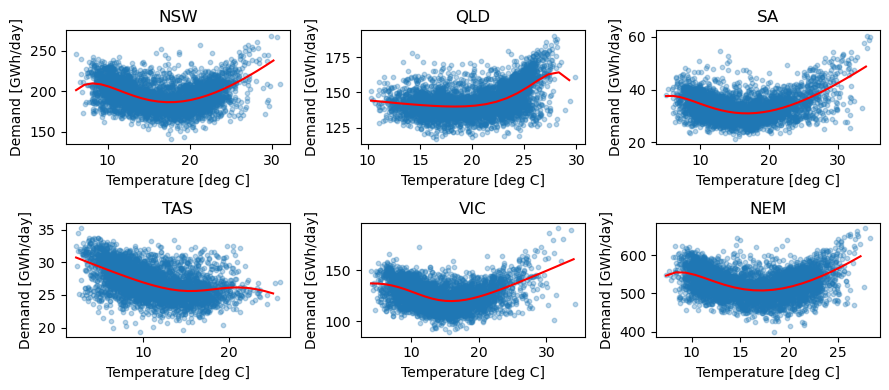

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(9,4))
for i, region in enumerate(aus_dem["region"].values):
    
    t = aus_t2m.sel(region=region, time=aus_dem["time"]) - 273.15
    d = aus_dem.sel(region=region) / 1000
    
    a1, a2, b1, b2, z, c = fit_model(t, d, inits=init)
    x_line = np.arange(min(t.values), max(t.values), 1)
    y_line = lstr(x_line, a1, a2, b1, b2, z, c)
    
    a = ax.flatten()[i]
    a.scatter(t, d, alpha=0.3, s=10)
    a.plot(x_line, y_line, color="r")
    a.set_xlabel("Temperature [deg C]")
    a.set_ylabel("Demand [GWh/day]")
    a.set_title(region)
plt.tight_layout()

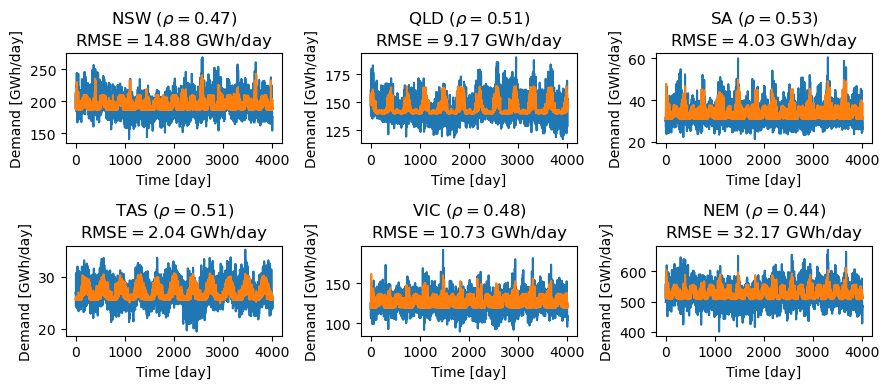

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(9,4))
for i, region in enumerate(aus_dem["region"].values):
    
    t = aus_t2m.sel(region=region, time=aus_dem["time"]) - 273.15
    d = aus_dem.sel(region=region) / 1000
    
    a1, a2, b1, b2, z, c = fit_model(t, d, inits=init)
    pred = lstr(t.values, a1, a2, b1, b2, z, c)
    
    cor, _ = np.round(pearsonr(d, pred), 2)
    rmse = np.round(np.sqrt(mean_squared_error(d, pred)), 2)
    
    a = ax.flatten()[i]
    a.plot(d)
    a.plot(pred)
    a.set_xlabel("Time [day]")
    a.set_ylabel("Demand [GWh/day]")
    a.set_title(region + r" ($\rho=$"+str(cor) + ")\n" + r"RMSE$=$" + str(rmse) + " GWh/day")
plt.tight_layout()

### Europe

In [7]:
init = [500, 300, -2, 2, 0.5, 10]

573.4936722758472 -1.538791051879764 421.1514572553504 2.079911760335895 0.3993076849103025 9.353154026584502


Text(0.5, 1.0, 'Europe')

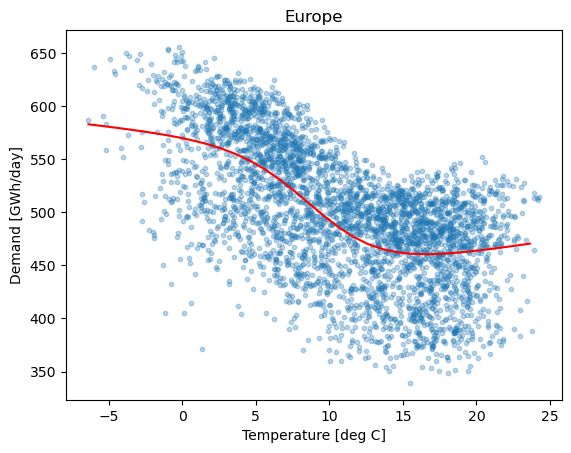

In [12]:
fig, ax = plt.subplots()
    
t = eu_t2m.sel(time=eu_dem["time"]) - 273.15
d = eu_dem / 1000

a1, a2, b1, b2, z, c = fit_model(t, d, inits=init)
print(a1, b1, a2, b2, z, c)
x_line = np.arange(min(t.values), max(t.values), 1)
y_line = lstr(x_line, a1, a2, b1, b2, z, c)

a = ax
a.scatter(t, d, alpha=0.3, s=10)
a.plot(x_line, y_line, color="r")
a.set_xlabel("Temperature [deg C]")
a.set_ylabel("Demand [GWh/day]")
a.set_title("Europe")

Text(0.5, 1.0, 'EU ($\\rho=$0.64)\nRMSE$=$47.59 GWh/day')

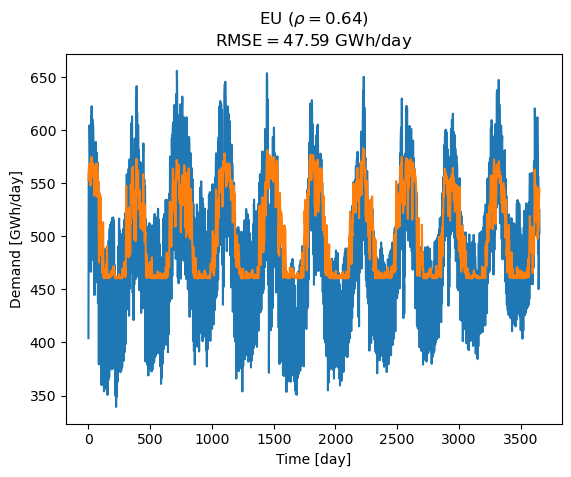

In [30]:
fig, ax = plt.subplots()
    
t = eu_t2m.sel(time=eu_dem["time"]) - 273.15
d = eu_dem / 1000

a1, a2, b1, b2, z, c = fit_model(t, d, inits=init)
pred = lstr(t.values, a1, a2, b1, b2, z, c)

cor, _ = np.round(pearsonr(d, pred), 2)
rmse = np.round(np.sqrt(mean_squared_error(d, pred)), 2)

a = ax
a.plot(d)
a.plot(pred)
a.set_xlabel("Time [day]")
a.set_ylabel("Demand [GWh/day]")
a.set_title("EU" + r" ($\rho=$"+str(cor) + ")\n" + r"RMSE$=$" + str(rmse) + " GWh/day")